# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [1]:
import gzip
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gc
sns.set()

In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

#### Reviews

In [3]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 1
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1

In [4]:
data_reviews = pd.DataFrame(data_reviews)

In [5]:
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075


In [6]:
data_reviews.isna().sum()*100/len(data_reviews)

username         0.000000
hours            0.340521
products         0.191978
product_id       0.000000
page_order       0.000000
date             0.000000
text             0.000000
early_access     0.000000
page             0.000000
found_funny     84.592001
compensation    98.131378
user_id         59.242976
dtype: float64

#### Games

In [7]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [8]:
data_games.head(2)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN


## Analisis Exploratorio 

### Preprocesamiento Reviews

Las columnas a continuacion no otorgan valor para el analisis exploratorio, se incluye la columna **user_id** porque tiene muchos valores faltantes, por lo tanto, el username se convierte en nuestro identificador unico de usuario. La columna **hours** permanece ya que se podria consultar cual fue el usuario que jugó mas tiempo o cual fue el videojuego con mayor tiempo de juego, igualmente con la columna **date** podemos averiguar cual fue el videojuego mas jugado de cada año, etc. Se excluye la columna **text** porque podriamos desarrollar NLP con esta feature.

In [9]:
data_reviews.drop(['products', 'page_order', 'early_access',
                   'page', 'user_id', 'compensation', 'found_funny'], axis=1, inplace=True)

In [10]:
data_reviews.head()

,username,hours,product_id,date,text
0,Chaos Syren,0.1,725280,2017-12-17,This would not be acceptable as an entertainme...
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,328100,2017-12-27,looks like a facebook game
2,hello?<,14.6,328100,2017-10-16,Better than Minecraft
3,Cyderine916,5.0,35140,2018-01-04,I love and idolized Batman and this game is Ma...
4,DarklyThinking,16.6,35140,2018-01-04,Still worth playing in 2018.\nProbably my favo...


In [13]:
data_reviews.shape

(7793069, 5)

Se analiza si existen registros duplicados en el dataset:

In [14]:
duplicated = data_reviews[data_reviews.duplicated()]
duplicated.shape

(831833, 5)

Se confirma la existencia registros duplicados, ahora se detalla un usuario aleatorio de estos registros:

In [15]:
duplicated.head()

,username,hours,product_id,date,text
2435,Foggy Dreamer,2.2,308040,2017-11-04,PROS:\n- Beautiful visuals and art\n- Decent p...
2632,little gamer64,20.5,271590,2018-01-04,I love this game
3264,Space_Wafer,7.4,427730,2017-12-31,So fun
3498,xanderwhovian,25.5,8880,2014-08-27,"freedom force is an absolutely amazing game, i..."
4028,feel it break,53.6,61700,2017-05-30,"Great and unique gameplay, lovely comic style ..."


Para probar, se selecciona el usuario **"Foggy Dreamer"**

In [16]:
data_reviews[data_reviews.username == 'feel it break']

,username,hours,product_id,date,text
3880,feel it break,53.6,61700,2017-05-30,"Great and unique gameplay, lovely comic style ..."
4028,feel it break,53.6,61700,2017-05-30,"Great and unique gameplay, lovely comic style ..."
179401,feel it break,14.5,48700,2017-12-30,Well the first few hours into the game I had a...
3498769,feel it break,3.1,435480,2017-12-07,What a f***ing piece of turd of a game this is...
5340520,feel it break,323.5,97330,2017-10-12,Of all the Magic Games that came out and that ...
5518204,feel it break,469.0,316010,2016-12-11,Pro: You can build own magic decks\nCons: .......
6861873,feel it break,56.7,204450,2017-10-12,"Amazing game, very fast paced, stylish, combat..."


Los registros de esta busqueda arrojan un evidente error de los datos, misma cantidad de horas, id de videojuego y fecha. Por lo tanto es razonable eliminar estos registros.

In [17]:
data_reviews.drop_duplicates(inplace=True, ignore_index=True)

In [18]:
data_reviews.shape

(6961236, 5)

Con esto se confirma finalmente la eliminacion de los registros duplicados.

In [19]:
data_reviews.duplicated().sum()

0

In [20]:
data_reviews.isna().sum()

username          0
hours         25941
product_id        0
date              0
text              0
dtype: int64

In [21]:
gc.collect()

40

### Preprocesamiento Games

In [22]:
data_games.head(3)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN


#### Valores faltantes

In [23]:
data_games.isna().sum()*100/len(data_games)

publisher         25.056792
genres            10.216275
app_name           0.006224
title              6.379337
url                0.000000
release_date       6.432239
tags               0.507235
discount_price    99.299829
reviews_url        0.006224
specs              2.084954
price              4.285047
early_access       0.000000
id                 0.006224
developer         10.266065
sentiment         22.349463
metascore         91.669519
dtype: float64

In [24]:
def heatmap_nan_values(data):
    plt.figure(figsize=(18, 10))
    nan_values = data.isna().sum()
    fig = sns.heatmap(data.isna(), cbar=False, yticklabels=False)
    col_width = fig.get_xlim()[1]/len(data.columns)
    for i, col in enumerate(data.columns):
        pos_text_x = col_width*(i+1/2)
        plt.text(pos_text_x, 0, nan_values[i], fontdict=dict(
            fontsize=15, rotation=33))
        plt.axvline(x=col_width*i, c='white', lw=2)

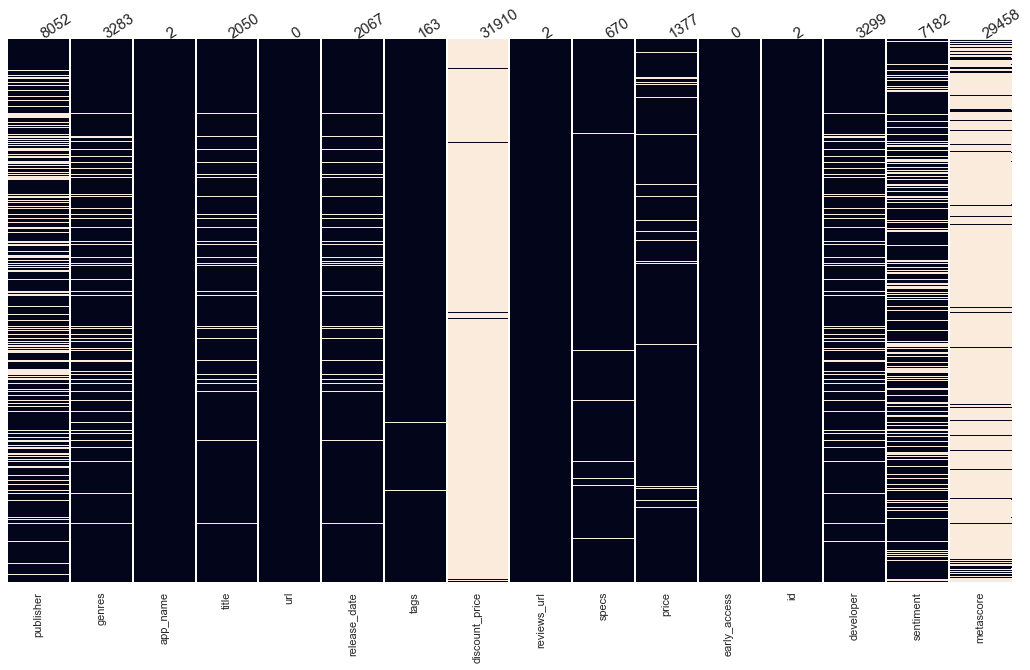

In [25]:
heatmap_nan_values(data_games)

In [26]:
data_games.shape

(32135, 16)

In [27]:
data_games.sentiment.value_counts()

Mixed                      4103
Very Positive              3868
Positive                   3281
Mostly Positive            2744
1 user reviews             2496
2 user reviews             1756
3 user reviews             1231
4 user reviews              964
5 user reviews              846
Mostly Negative             802
6 user reviews              756
7 user reviews              619
8 user reviews              537
9 user reviews              488
Overwhelmingly Positive     303
Negative                    123
Very Negative                29
Overwhelmingly Negative       7
Name: sentiment, dtype: int64

* Las columnas a continuacion no otorgan valor para el analisis exploratorio, se incluyen algunas con valores faltantes superiores al 90% del total de los datos.
* Columnas como **"genre"** y **"tag"** otorgan casi la misma informacion con la unica diferencia que "genre" posee mas valores faltantes.
* La columna **"sentiment"** se exluiria tambien ya que posee muchas categorias, algunas de ellas no son predecibles y no se podrian agrupar en categorias generales.
* El resto de columnas no incluidas aqui serviran para un posterior analisis exploratorio.

In [28]:
data_games.drop(columns=['publisher', 'genres', 'title', 'discount_price', 'reviews_url',
                         'specs', 'early_access', 'developer', 'sentiment', 'metascore'], inplace=True)

In [29]:
data_games.isna().sum()

app_name           2
url                0
release_date    2067
tags             163
price           1377
id                 2
dtype: int64

**Videjuegos con app_name faltante:**

El nombre de la aplicacion es importante a la hora de conocer que aplicacion se va a recomendar.

In [30]:
data_games[data_games.app_name.isna()]

,app_name,url,release_date,tags,price,id
74,NaN,http://store.steampowered.com/,NaN,NaN,19.99,NaN
2580,NaN,http://store.steampowered.com/app/317160/_/,2014-08-26,"[Action, Indie]",NaN,317160


**Videjuegos con id faltante:**

El id del videojuego tambien es identificador importante y no se debe ignorar.

In [31]:
data_games[data_games.id.isna()]

,app_name,url,release_date,tags,price,id
74,NaN,http://store.steampowered.com/,NaN,NaN,19.99,NaN
30961,Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",19.99,NaN


* Ambas busquedas coinciden en un registro para un videojuego que no existe (registro 74), se puede verificar examinando su url la cual no esta compuesta por id ni nombre del videojuego.
* El segundo registro obtenido con nombres faltantes corresponde a un videojuego que, al parecer, se migro a otra url o ha caducado. Para este videojuego con id 317160 encontramos que tampoco existen reviews, por lo tanto, se pueden eliminar estos dos elementos.

In [32]:
data_reviews.query('product_id == "317160"')

,username,hours,product_id,date,text


Sin embargo al acceder a la url (http://store.steampowered.com/app/317160/_/) del videojuego en cuestion no aparece titulo, ni imagenes adjuntas, pero en la portada del videjuego se logra apreciar su nombre: "Duet", y al tratar de consultar por este nombre en el dataset el resultado obtenido es:

In [33]:
query_duet = data_games.query('app_name == "Duet"')
query_duet

,app_name,url,release_date,tags,price,id
4103,Duet,http://store.steampowered.com/app/292600/Duet/,2015-08-03,"[Indie, Action, Minimalist, Great Soundtrack, ...",4.99,292600


El cual si contiene reviews asociados:

In [34]:
duet = query_duet.iloc[0]
print(f'Duet: {duet.id}')
data_reviews.query('product_id == @duet.id')

Duet: 292600


,username,hours,product_id,date,text
6142810,nomomonopoly,18.6,292600,2018-01-03,There are a few games that manage to exceed wi...
6142811,brandtware,8.1,292600,2018-01-02,This is the only game I have ever played which...
6142812,Suh❀,1.9,292600,2017-12-29,"Very, very good. I love it, one of my favorite..."
6142816,AbsoluteZer0,0.1,292600,2017-12-27,+ Simple to play - hard to master: You have 2 ...
6142817,Ninjax,1.3,292600,2017-12-25,"A wonderful game! I've played on mobile, and n..."
...,...,...,...,...,...
6147715,Geoff_12889,3.8,292600,2015-08-04,"This game is exactly like the mobile game, and..."
6147716,Aetos,7.5,292600,2015-08-04,"It’s perfect, highly recommend.\nFan of Super ..."
6147717,Zia,2.5,292600,2015-08-03,A marvellous and inspiring little game with a ...
6147718,Child Labor Work Force,7.8,292600,2015-08-03,"""Difficult""and ""Rogue"" should be added to the ..."


Aplicando dropna() al dataset con valores faltantes por la columna **"app_name"**

In [35]:
data_games.dropna(subset=['app_name'], inplace=True)

In [36]:
data_games.shape

(32133, 6)

In [37]:
data_games.isna().sum()

app_name           0
url                0
release_date    2066
tags             162
price           1376
id                 1
dtype: int64

Es importante que la columna **"id"** este sin valores faltantes dado que el modelo en la segunda etapa de este proyecto lo requerira, el resto de campos tendra mayor uso para realizar consultas. Dado lo anterior, se aplicara el siguiente analisis para rellenar este valor:

In [38]:
data_games[data_games.id.isna()]

,app_name,url,release_date,tags,price,id
30961,Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",19.99,NaN


**Rellenando columna "id"**

Vemos que la url contiene el id faltante y en este caso se obtuvo un solo registro, con un simple _"copy - paste"_ de este id y conociendo el indice se podria solucionar, pero si se hubieran obtenido multiples registros seria una tarea tediosa, entonces se realizara un "loop" sobre estos videojuegos para completar el id. 

In [39]:
data_games.loc[30961]

app_name           Batman: Arkham City - Game of the Year Edition
url                      http://store.steampowered.com/app/200260
release_date                                           2012-09-07
tags            [Action, Open World, Batman, Adventure, Stealt...
price                                                       19.99
id                                                            NaN
Name: 30961, dtype: object

Split basico a una url para obtener el id:

In [40]:
'http://store.steampowered.com/app/200260'.split('app/')[1].split('/')[0]

'200260'

Aplicando la estrategia en un loop:

In [41]:
index_id_nan = data_games[data_games.id.isna()].index
for idx in index_id_nan:
    url = data_games.loc[idx].url
    id_game = url.split('app/')[1].split('/')[0]
    data_games.loc[idx].id = id_game

In [42]:
data_games[data_games.index == 30961]

,app_name,url,release_date,tags,price,id
30961,Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",19.99,200260


In [43]:
data_games.isna().sum()

app_name           0
url                0
release_date    2066
tags             162
price           1376
id                 0
dtype: int64

#### Filtrado de categorias en precio

La columna "price" esta conforma por valores numericos y categoricos, entonces haremos un filtro para obtener y analizar estas categorias.

In [44]:
prices = np.array([i for i in list(data_games.price) if (type(i) == str)])
np.unique(prices)

array(['Free', 'Free Demo', 'Free HITMAN™ Holiday Pack', 'Free Mod',
       'Free Movie', 'Free To Play', 'Free to Play', 'Free to Try',
       'Free to Use', 'Install Now', 'Install Theme', 'Play Now',
       'Play WARMACHINE: Tactics Demo', 'Play for Free!', 'Play the Demo',
       'Starting at $449.00', 'Starting at $499.00', 'Third-party'],
      dtype='<U29')

Se observa dos veces la categoria "Starting at $449.00", parece que el metodo np.unique() lo distinguio como categorias diferentes, algo inusual.  

A continuacion se realizara un filtrado para explorar algunas categorias bastante curiosas por su nombre: "Install Now", "Install Theme", "Free movie", y "Starting at $499" 

In [45]:
prices_not_allowed = ['Install Now', 'Install Theme', 'Free Movie']
games_invalid = [game for game in data_games.itertuples()
                 if ((type(game.price) == str) and ((game.price in prices_not_allowed) or game.price.startswith('Starting')))]
games_invalid = pd.DataFrame(games_invalid)
games_invalid

,Index,app_name,url,release_date,tags,price,id
0,2405,EVGA Precision XOC,http://store.steampowered.com/app/268850/EVGA_...,2014-09-19,"[Utilities, Software, Free to Play]",Install Now,268850
1,3832,FREE China Theme Pack,http://store.steampowered.com/app/370880/FREE_...,2015-06-10,"[Adventure, RPG, Indie, Casual, Simulation]",Install Theme,370880
2,25000,Syber Steam Machine,http://store.steampowered.com/app/353420/Syber...,2015-11-10,"[Steam Machine, Hardware]",Starting at $499.00,353420
3,25001,Alienware Steam Machine,http://store.steampowered.com/app/353390/Alien...,2015-11-10,"[Steam Machine, Hardware, Gaming, Futuristic, ...",Starting at $449.00,353390
4,29366,Free to Play,http://store.steampowered.com/app/245550/Free_...,2014-03-19,"[Free to Play, Documentary, e-sports]",Free Movie,245550


Al investigar en profundidad estas categorias mediante la url descubrimos que estos registros no corresponden a videojuegos:
* **EVGA Precision XOC**: Software que ayuda a la configuracion de la tarjeta grafica (Ejemplo: https://www.evga.com/precisionxoc/)
* **FREE China Theme Pack**: Decorador de videojuegos adaptando tematica relacionada a la cultura china.
* **Syber Steam Machine** y **Alienware Steam Machine**: Son unidades de hardware con un sistema operativo nativo Steam OS para brindar mejor experiencia de juego. (Ejemplo: https://www.cyberpowerpc.com/system/Syber-Steam-Machine-Core)
* **Free to Play**: Video/Documental acerca de videojuegos.

Eliminando registros detectados del dataset de videojuegos, los registros a filtrar estan en una nueva variable:

In [46]:
data_games.drop(games_invalid.Index, inplace=True)
data_games.reset_index(drop=True, inplace=True)

In [47]:
print(data_games.shape)
data_games

(32128, 6)


,app_name,url,release_date,tags,price,id
0,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.99,761140
1,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",Free To Play,643980
2,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",Free to Play,670290
3,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.99,767400
4,Log Challenge,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",2.99,773570
...,...,...,...,...,...,...
32123,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.99,773640
32124,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",4.99,733530
32125,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",1.99,610660
32126,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",4.99,658870


In [48]:
data_games.isna().sum()

app_name           0
url                0
release_date    2066
tags             162
price           1376
id                 0
dtype: int64

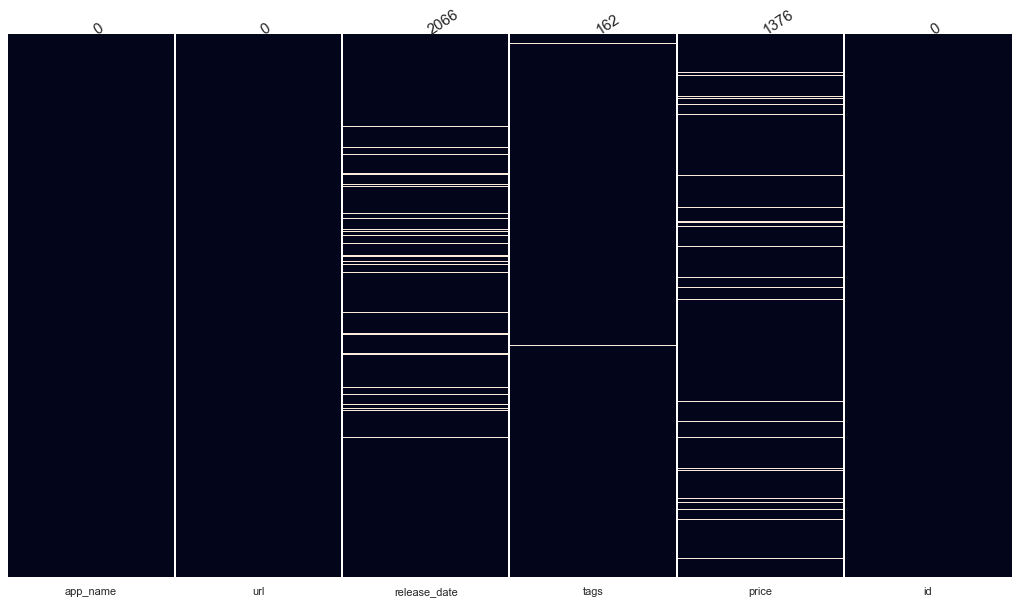

In [49]:
heatmap_nan_values(data_games)

Ahora examinaremos los reviews existentes de estas 4 categorias:

In [50]:
merge_reviews = pd.merge(data_reviews, games_invalid, left_on='product_id', right_on='id')
print(merge_reviews.shape)
merge_reviews.head(3)

(6289, 12)


,username,hours,product_id,date,text,Index,app_name,url,release_date,tags,price,id
0,newabcd,1578.9,268850,2018-01-05,Does the job very well.,2405,EVGA Precision XOC,http://store.steampowered.com/app/268850/EVGA_...,2014-09-19,"[Utilities, Software, Free to Play]",Install Now,268850
1,Rucko,318.3,268850,2018-01-04,I checked which of my games had the most hours...,2405,EVGA Precision XOC,http://store.steampowered.com/app/268850/EVGA_...,2014-09-19,"[Utilities, Software, Free to Play]",Install Now,268850
2,chiken,242.6,268850,2018-01-03,Best RPG ever 10/10,2405,EVGA Precision XOC,http://store.steampowered.com/app/268850/EVGA_...,2014-09-19,"[Utilities, Software, Free to Play]",Install Now,268850


Shape de la ultima version del dataset de reviews:

In [51]:
data_reviews.shape

(6961236, 5)

#### Filtrando reviews

Filtrando reviews que pertenecen a estas categorias:

In [52]:
data_reviews.query('product_id not in @games_invalid.id', inplace=True)

In [53]:
data_reviews.shape

(6954947, 5)

#### Transformando categorias

Creando nuevas categorias para la columna precio, actualmente contamos con valores numericos y categoricos:

In [54]:
paid_games = 0
price_categories = []
for price in data_games.price:
    if type(price) == str:
        price_categories.append(price.lower().strip())
    else:
        paid_games += 1
print('Videojuegos de pago:', paid_games)
print('Videojuegos con categoria de precios:', (pd.Series(price_categories).value_counts()))

Videojuegos de pago: 30223
Videojuegos con categoria de precios: free to play                     982
free                             905
free mod                           4
free demo                          3
play for free!                     2
play now                           2
third-party                        2
play warmachine: tactics demo      1
play the demo                      1
free to use                        1
free hitman™ holiday pack          1
free to try                        1
dtype: int64


In [55]:
data_games['category_price'] = data_games.price.apply(
    lambda p: 'paid' if (type(p) == float) else 'free')
data_games.head()

,app_name,url,release_date,tags,price,id,category_price
0,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.99,761140,paid
1,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",Free To Play,643980,free
2,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",Free to Play,670290,free
3,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.99,767400,paid
4,Log Challenge,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",2.99,773570,paid


In [56]:
gc.collect()

7164

### Exportando Datasets

In [57]:
data_reviews.to_csv('data_processed/data_reviews.csv', index=False)
data_games.to_csv('data_processed/data_games.csv', index=False)

### Consultas

In [58]:
data_reviews = pd.read_csv('data_processed/data_reviews.csv')

#Aqui se convierte cada elemento de tag en una lista
data_games = pd.read_csv('data_processed/data_games.csv',
                         converters={'tags': lambda x: x[1:-1].replace("'", '').split(', ')}) 

In [59]:
data_games.isna().sum()

app_name             0
url                  0
release_date      2066
tags                 0
price             1376
id                   0
category_price       0
dtype: int64

In [60]:
data_reviews.head()

,username,hours,product_id,date,text
0,Chaos Syren,0.1,725280,2017-12-17,This would not be acceptable as an entertainme...
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,328100,2017-12-27,looks like a facebook game
2,hello?<,14.6,328100,2017-10-16,Better than Minecraft
3,Cyderine916,5.0,35140,2018-01-04,I love and idolized Batman and this game is Ma...
4,DarklyThinking,16.6,35140,2018-01-04,Still worth playing in 2018.\nProbably my favo...


In [61]:
data_games.head()

,app_name,url,release_date,tags,price,id,category_price
0,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.99,761140,paid
1,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",Free To Play,643980,free
2,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",Free to Play,670290,free
3,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.99,767400,paid
4,Log Challenge,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",2.99,773570,paid


In [ ]:
data_reviews.isna().sum()

#### Usuarios únicos

In [ ]:
print(f'{len(data_reviews.username.value_counts())} usuarios únicos')

#### Top 10 videojuegos mas populares

In [ ]:
amount_by_productId = data_reviews.groupby('product_id').product_id.count().reset_index(name='amount')
amount_by_productId

Merge entre videojuegos y reviews:

In [ ]:
merge_reviews_games = pd.merge(amount_by_productId, data_games, left_on='product_id',
                               right_on='id').sort_values(by='amount', ascending=False)

In [ ]:
top10 = merge_reviews_games.head(10)

In [ ]:
# Configuracion de fuentes

fontdict_title = {'fontsize': 17, 'fontweight': 'bold'}
fontdict_axis = {'fontsize': 14}

Funcion configurada para graficar diagrama de barra con estilos y fuentes

In [ ]:
def barplot_games(title, df_merged, rotation=20):
    plt.figure(figsize=(15, 5))
    plt.title(title, fontdict=fontdict_title)
    sns.barplot(df_merged.app_name, df_merged.amount, palette='ocean')
    plt.xlabel('Videojuegos', fontdict=fontdict_axis)
    plt.ylabel('Cantidad de usuarios', fontdict=fontdict_axis)
    plt.xticks(rotation=rotation)

In [ ]:
top10

In [ ]:
barplot_games('Top 10 Mas jugados', top10)

#### Videojuego mas popular

In [ ]:
tail10 = merge_reviews_games.tail(10)

In [ ]:
barplot_games('Videojuegos menos populares', tail10, rotation=80)

#### Top 10 Videojuegos de accion mas populares

In [ ]:
def games_by_tag(tag):
    return pd.DataFrame(item for item in data_games.itertuples()
                         if (tag in item.tags))

In [ ]:
df_items = games_by_tag('Action')
df_items.head()

In [ ]:
merge_action_games = pd.merge(amount_by_productId, df_items, left_on='product_id',
                              right_on='id').sort_values(by='amount', ascending=False).head(10)

In [ ]:
barplot_games('Top 10 videojuegos de accion', merge_action_games)

#### Videojuegos RPG mas populares

In [ ]:
df_items = games_by_tag('RPG')
merge_adventure_games = pd.merge(amount_by_productId, df_items, left_on='product_id',
                              right_on='id').sort_values(by='amount', ascending=False).head(10)

In [ ]:
barplot_games('Top 10 videojuegos RPG', merge_adventure_games)

#### Videojuegos de deporte mas jugados

In [ ]:
df_items = games_by_tag('Sports')
merge_sport_games = pd.merge(amount_by_productId, df_items, left_on='product_id',
                              right_on='id').sort_values(by='amount', ascending=False).head(10)

In [ ]:
barplot_games('Top 10 videojuegos de deporte', merge_sport_games, rotation=70)

#### Videojuegos de pago mas jugados

In [ ]:
df_items = data_games.query('category_price=="paid"')
merge_paid_games = pd.merge(amount_by_productId, df_items, left_on='product_id',
                            right_on='id').sort_values(by='amount', ascending=False).head(10)

In [ ]:
barplot_games('Videojuegos de pago mas populares', merge_paid_games)

#### Videojuegos gratis mas jugados

In [ ]:
df_items = data_games.query('category_price=="free"')
merge_free_games = pd.merge(amount_by_productId, df_items, left_on='product_id',
                              right_on='id').sort_values(by='amount', ascending=False).head(10)

In [ ]:
barplot_games('Videojuegos gratis mas populares', merge_free_games)

#### Cantidad de usuarios por precio de videojuego

In [ ]:
sum_amount_categories = (merge_reviews_games.groupby('category_price').amount.sum()
                         / merge_reviews_games.amount.sum()).to_frame(name='total_amount').reset_index()
sum_amount_categories.sort_values(
    by='total_amount', ascending=False, inplace=True)
sum_amount_categories

In [ ]:
plt.figure(figsize=(7, 5))
plt.title('% Usuarios por precio', fontdict=fontdict_title)
sns.barplot(x='category_price', y='total_amount',
            data=sum_amount_categories, palette='mako')
plt.xlabel('Categoria de precios', fontdict=fontdict_axis)
plt.ylabel('% Usuarios', fontdict=fontdict_axis)

#### Algo con series de tiempo

#### Algo con NPL

**Liberando memoria**

In [ ]:
gc.collect()

## Sistema de recomendacion